
# 🖼️ RGB: estrazione dei canali e semplici operazioni di image editing (interattivo)

Questo notebook mostra:
1) **Come caricare un'immagine** e leggere i **canali R, G, B** come matrici numeriche.  
2) **Come intervenire sui numeri** (con addizioni, moltiplicazioni, convoluzioni) per realizzare semplici editing: luminosità, contrasto, gamma, bilanciamento colore, sfocatura, nitidezza, edge detection, scambio canali, mascheratura.

> Puoi **caricare un'immagine** tua; se non lo fai, il notebook genera una **demo sintetica**.


## 0) Requisiti (esegui una volta se necessario)

In [ ]:

# Se serve, scommenta:
# !pip install ipywidgets numpy pillow matplotlib scipy
# !jupyter nbextension enable --py widgetsnbextension


## 1) Import e funzioni di base

In [18]:

import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import ipywidgets as widgets
from IPython.display import display, clear_output

def to_np(img_pil):
    """Converte PIL Image in array float32 [0,1]."""
    arr = np.asarray(img_pil.convert('RGB'), dtype=np.float32) / 255.0
    return arr

def to_pil(arr):
    """Converte array float32 [0,1] in PIL Image RGB."""
    arr_c = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    return Image.fromarray(arr_c, mode='RGB')

def demo_image(w=512, h=320):
    """Crea un'immagine sintetica con gradienti e forme per esperimenti."""
    img = Image.new('RGB', (w, h), (255, 255, 255))
    d = ImageDraw.Draw(img)
    # gradiente orizzontale rosso
    for x in range(w):
        r = int(255 * x / (w-1))
        d.line([(x,0),(x,h//2)], fill=(r, 80, 60))
    # gradiente verticale verde
    for y in range(h//2, h):
        g = int(255 * (y - h//2) / (h//2 - 1))
        d.line([(0,y),(w-1,y)], fill=(60, g, 180))
    # forme
    d.rectangle([30,30,170,150], outline=(255,255,255), width=4)
    d.ellipse([220,40,360,180], outline=(255,255,0), width=6)
    d.polygon([(420,60),(470,160),(370,160)], outline=(0,0,0), fill=(0,120,220))
    return img

# immagine globale di lavoro (PIL & numpy)
ORIG_PIL = demo_image()
ORIG = to_np(ORIG_PIL)

def show_image(img_np, title="Immagine"):
    plt.figure()
    plt.imshow(np.clip(img_np, 0, 1))
    plt.axis('off')
    plt.title(title)
    plt.show()



## 2) Carica un'immagine (opzionale)
Se non carichi nulla, useremo una **demo** creata artificialmente.


Output()

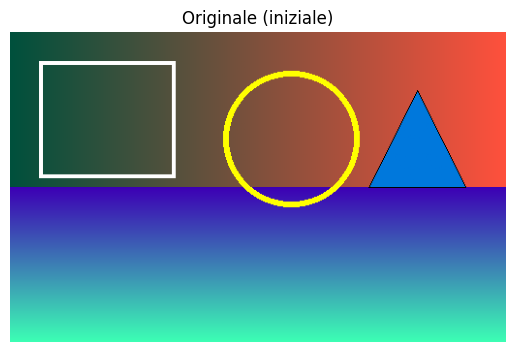

In [19]:

uploader = widgets.FileUpload(accept='image/*', multiple=False)
use_demo_btn = widgets.Button(description="Usa immagine demo", button_style="")
load_out = widgets.Output()

def on_upload_change(change):
    global ORIG_PIL, ORIG
    if uploader.value:
        if isinstance(uploader.value, dict):
            # vecchia API
            key = list(uploader.value.keys())[0]
            content = uploader.value[key]['content']
        else:
            # nuova API: tuple di dict
            content = uploader.value[0]['content']
        ORIG_PIL = Image.open(io.BytesIO(content))
        ORIG = to_np(ORIG_PIL)
        with load_out:
            clear_output()
            print("Immagine caricata — shape:", ORIG.shape)
            show_image(ORIG, "Originale (caricata)")
            
def on_use_demo(_):
    global ORIG_PIL, ORIG
    ORIG_PIL = demo_image()
    ORIG = to_np(ORIG_PIL)
    with load_out:
        clear_output()
        print("Usata immagine demo sintetica — shape:", ORIG.shape)
        show_image(ORIG, "Originale (demo)")

uploader.observe(on_upload_change, names='value')
use_demo_btn.on_click(on_use_demo)

display(widgets.HBox([uploader, use_demo_btn]))
display(load_out)

# Mostra l'immagine iniziale di default (demo)
show_image(ORIG, "Originale (iniziale)")



## 3) Estrarre i canali **R, G, B** come matrici
Un'immagine RGB è un tensore **H×W×3** in cui l'ultima dimensione contiene R, G, B.  
Possiamo visualizzare ogni canale come **grayscale** (intensità) o come **overlay** nel suo colore.


Shape: (300, 230, 3) — dtype: float32 — range ~[ 0.0 , 1.0 ]


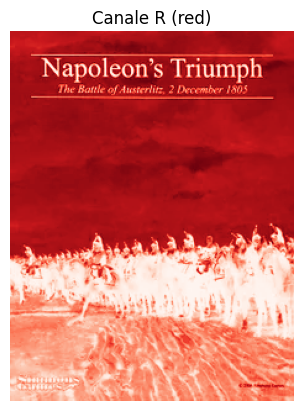

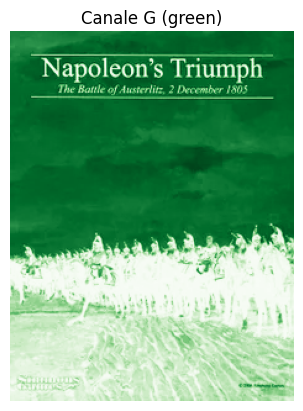

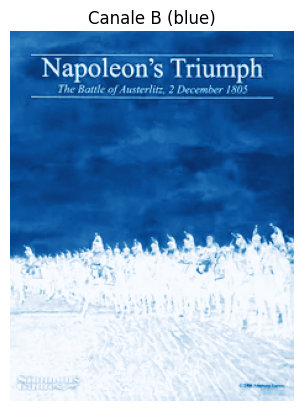

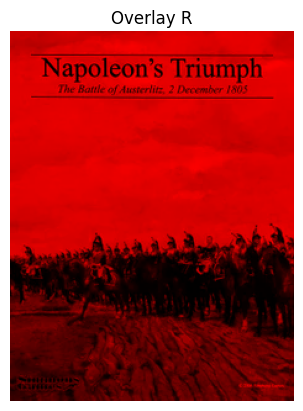

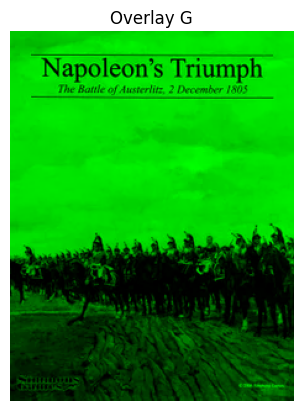

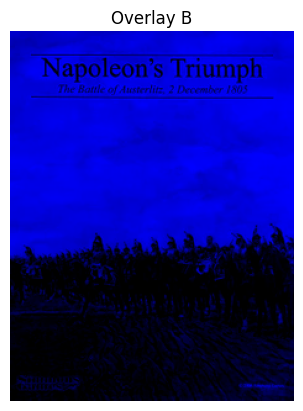

In [26]:

import numpy as np

R = ORIG[:,:,0]
G = ORIG[:,:,1]
B = ORIG[:,:,2]

print("Shape:", ORIG.shape, "— dtype:", ORIG.dtype, "— range ~[", ORIG.min(), ",", ORIG.max(), "]")

Rm = R.copy()
Rm[40:80, :] = np.ones((40, R.shape[1]))

# Visualizzazione canali (grayscale)
plt.figure()
plt.imshow(R, cmap='Reds', vmin=0, vmax=1)
plt.axis('off')
plt.title("Canale R (red)")
plt.show()

plt.figure()
plt.imshow(G, cmap='Greens', vmin=0, vmax=1)
plt.axis('off')
plt.title("Canale G (green)")
plt.show()

plt.figure()
plt.imshow(B, cmap='Blues', vmin=0, vmax=1)
plt.axis('off')
plt.title("Canale B (blue)")
plt.show()

# Overlay colore (impostando gli altri canali a zero)
show_image(np.dstack([R, np.zeros_like(R), np.zeros_like(R)]), "Overlay R")
show_image(np.dstack([np.zeros_like(G), G, np.zeros_like(G)]), "Overlay G")
show_image(np.dstack([np.zeros_like(B), np.zeros_like(B), B]), "Overlay B")


In [21]:
print(R.shape)

print(R)

(300, 230)
[[0.7921569  0.7921569  0.7921569  ... 0.77254903 0.7764706  0.7764706 ]
 [0.7921569  0.7921569  0.7921569  ... 0.7764706  0.7764706  0.7764706 ]
 [0.7921569  0.7921569  0.7921569  ... 0.7764706  0.7764706  0.7764706 ]
 ...
 [0.23921569 0.22352941 0.20784314 ... 0.26666668 0.28627452 0.2901961 ]
 [0.23921569 0.22352941 0.20784314 ... 0.25882354 0.28235295 0.28627452]
 [0.23921569 0.22352941 0.20784314 ... 0.27058825 0.29411766 0.3019608 ]]



## 4) Operazioni base: **luminosità**, **contrasto**, **gamma**, **bilanciamento colore**
Queste operazioni modificano i valori numerici dei pixel:
- **Luminosità**: addizione di una costante.
- **Contrasto**: moltiplicazione attorno a un punto centrale (es. 0.5).
- **Gamma**: trasformazione non lineare $x \mapsto x^{\gamma}$.
- **Bilanciamento colore**: moltiplicatori diversi per R,G,B.


In [27]:

# Widget interattivi
bright = widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.01, description="Luminosità")
contrast = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.01, description="Contrasto")
gamma = widgets.FloatSlider(value=1.0, min=0.2, max=3.0, step=0.05, description="Gamma")

r_gain = widgets.FloatSlider(value=1.0, min=0.0, max=2.5, step=0.05, description="R ×")
g_gain = widgets.FloatSlider(value=1.0, min=0.0, max=2.5, step=0.05, description="G ×")
b_gain = widgets.FloatSlider(value=1.0, min=0.0, max=2.5, step=0.05, description="B ×")

apply_btn = widgets.Button(description="Applica e mostra", button_style="success")
reset_btn = widgets.Button(description="Reset", button_style="warning")
out_edit = widgets.Output()

def apply_basic_edits(_=None):
    img = ORIG.copy()
    # luminosità
    img = img + bright.value
    # contrasto attorno a 0.5
    img = (img - 0.5) * contrast.value + 0.5
    # bilanciamento colore
    gains = np.array([r_gain.value, g_gain.value, b_gain.value])[None,None,:]
    img = img * gains
    # gamma (evita negativi prima)
    img = np.clip(img, 0, 1)
    img = np.power(img, gamma.value)
    with out_edit:
        fig, ax = plt.subplots(ncols=2)
        clear_output(wait=True)
        ax[0].imshow(np.clip(ORIG, 0, 1))
        ax[0].set_title("Originale")
        ax[1].imshow(np.clip(img, 0, 1))
        ax[1].set_title("Modificata (Lum/Contr/Gamma/Bilancio)")
        plt.show()
    # memorizza per salvataggio
    globals()['LAST_IMG'] = img

def reset_basic_edits(_=None):
    bright.value = 0.0
    contrast.value = 1.0
    gamma.value = 1.0
    r_gain.value = g_gain.value = b_gain.value = 1.0
    apply_basic_edits()

apply_btn.on_click(apply_basic_edits)
reset_btn.on_click(reset_basic_edits)

controls = widgets.VBox([bright, contrast, gamma, r_gain, g_gain, b_gain, widgets.HBox([apply_btn, reset_btn])])
display(controls, out_edit)
apply_basic_edits()


Output()


## 5) Operazioni sui canali: **scambio**, **mixing**, **grayscale**, **soglia**
- **Swap canali** (es. R↔B) per effetti creativi.
- **Mixing lineare** con matrice 3×3 (color transform).
- **Grayscale** come combinazione pesata (es. Rec.709): 0.2126 R + 0.7152 G + 0.0722 B.
- **Soglia** per posterizzazione/bianco-nero.


In [28]:

swap_btn = widgets.Dropdown(options=[("Nessuno", "none"), ("R↔B", "rb"), ("R↔G", "rg"), ("G↔B", "gb")], description="Swap:")
thr = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description="Soglia")
mix_apply = widgets.Button(description="Applica trasformazioni", button_style="success")
ops_out = widgets.Output()

# matrice 3x3 per mixing
M = np.eye(3).astype(np.float32)
M_sliders = [[widgets.FloatText(value=float(M[i,j]), description=f"M{i+1}{j+1}", layout=widgets.Layout(width="120px")) for j in range(3)] for i in range(3)]
M_grid = widgets.VBox([widgets.HBox(row) for row in M_sliders])

def apply_channel_ops(_=None):
    img = ORIG.copy()
    # swap
    if swap_btn.value != "none":
        if swap_btn.value == "rb":
            img = img[..., [2,1,0]]
        elif swap_btn.value == "rg":
            img = img[..., [1,0,2]]
        elif swap_btn.value == "gb":
            img = img[..., [0,2,1]]
    # mixing 3x3
    M = np.array([[M_sliders[i][j].value for j in range(3)] for i in range(3)], dtype=np.float32)
    h,w,_ = img.shape
    img_lin = img.reshape(-1,3)
    img_mixed = img_lin @ M.T
    img_mixed = img_mixed.reshape(h,w,3)
    img_mixed = np.clip(img_mixed, 0, 1)

    # grayscale + soglia
    gray = 0.2126*img_mixed[...,0] + 0.7152*img_mixed[...,1] + 0.0722*img_mixed[...,2]
    bw = (gray >= thr.value).astype(np.float32)

    with ops_out:
        clear_output(wait=True)
        show_image(ORIG, "Originale")
        show_image(img_mixed, "Dopo swap/mixing (3×3)")
        plt.figure()
        plt.imshow(gray, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.title("Grayscale (Rec.709)")
        plt.show()
        plt.figure()
        plt.imshow(bw, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.title("Bianco/Nero (soglia)")
        plt.show()
    globals()['LAST_IMG'] = img_mixed

display(widgets.HBox([swap_btn, thr]))
display(M_grid, mix_apply, ops_out)
mix_apply.on_click(apply_channel_ops)
apply_channel_ops()


Button(button_style='success', description='Applica trasformazioni', style=ButtonStyle())

Output()

/var/folders/t2/dvy2q49d2vsc731h1cfy6dnr0000gn/T/ipykernel_4485/1605600500.py:25: RuntimeWarning: divide by zero encountered in matmul
  img_mixed = img_lin @ M.T
/var/folders/t2/dvy2q49d2vsc731h1cfy6dnr0000gn/T/ipykernel_4485/1605600500.py:25: RuntimeWarning: overflow encountered in matmul
  img_mixed = img_lin @ M.T
/var/folders/t2/dvy2q49d2vsc731h1cfy6dnr0000gn/T/ipykernel_4485/1605600500.py:25: RuntimeWarning: invalid value encountered in matmul
  img_mixed = img_lin @ M.T



## 6) Convoluzioni 3×3: **sfocatura**, **nitidezza**, **edge detection**
Applichiamo un kernel 3×3 ai canali (indipendentemente).


In [ ]:

import numpy as np

def conv2d_channel(img, K):
    # convoluzione valida per un canale con padding 'reflect'
    H,W = img.shape
    kH,kW = K.shape
    pad_h = kH//2
    pad_w = kW//2
    padded = np.pad(img, ((pad_h,pad_h),(pad_w,pad_w)), mode='reflect')
    out = np.zeros_like(img)
    for y in range(H):
        for x in range(W):
            region = padded[y:y+kH, x:x+kW]
            out[y,x] = np.sum(region * K)
    return out

KERNELS = {
    "Identità": np.array([[0,0,0],[0,1,0],[0,0,0]], dtype=np.float32),
    "Blur leggero": (1/9.0)*np.ones((3,3), dtype=np.float32),
    "Sharpen": np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=np.float32),
    "Edge (Sobel X)": np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32),
    "Edge (Sobel Y)": np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32),
    "Emboss": np.array([[-2,-1,0],[-1,1,1],[0,1,2]], dtype=np.float32),
}

kernel_dd = widgets.Dropdown(options=list(KERNELS.keys()), description="Kernel:")
apply_kernel_btn = widgets.Button(description="Applica kernel", button_style="success")
conv_out = widgets.Output()

def on_apply_kernel(_=None):
    K = KERNELS[kernel_dd.value]
    img = ORIG.copy()
    out = np.zeros_like(img)
    for c in range(3):
        out[...,c] = conv2d_channel(img[...,c], K)
    out = np.clip(out, 0, 1)
    with conv_out:
        fig, ax = plt.subplots(ncols=2)
        clear_output(wait=True)
        ax[0].imshow(np.clip(ORIG, 0, 1))
        ax[0].set_title("Originale")
        ax[1].imshow(np.clip(out, 0, 1))
        ax[1].set_title(f"Dopo convoluzione 3×3 ({kernel_dd.value})")
        plt.show()
    globals()['LAST_IMG'] = out

display(widgets.HBox([kernel_dd, apply_kernel_btn]), conv_out)
apply_kernel_btn.on_click(on_apply_kernel)
on_apply_kernel()


Output()


## 7) Maschere e selezioni semplici
Esempio: schiarire solo i pixel con **G** (verde) alto e scurire il resto.


In [ ]:

mask_thr = widgets.FloatSlider(value=0.6, min=0.0, max=1.0, step=0.01, description="Soglia G")
mask_apply_btn = widgets.Button(description="Applica maschera", button_style="success")
mask_out = widgets.Output()

def on_apply_mask(_=None):
    img = ORIG.copy()
    mask = (img[...,1] >= mask_thr.value).astype(np.float32)[...,None]
    edited = img * (0.8 + 0.4*mask)  # se mask=1 → ×1.2, altrimenti ×0.8
    edited = np.clip(edited, 0, 1)
    with mask_out:
        clear_output(wait=True)
        plt.figure()
        plt.imshow(mask.squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.title("Maschera (1 = zona modificata)")
        plt.show()
        show_image(ORIG, "Originale")
        show_image(edited, "Dopo maschera su canale G")
    globals()['LAST_IMG'] = edited

display(widgets.HBox([mask_thr, mask_apply_btn]), mask_out)
mask_apply_btn.on_click(on_apply_mask)
on_apply_mask()


Output()


## 8) Salva l'immagine modificata
Usa questo pulsante dopo l'operazione che ti interessa (l'ultima immagine mostrata viene salvata).


In [ ]:

from PIL import Image

save_btn = widgets.Button(description="Salva ultima immagine", button_style="warning")
save_out = widgets.Output()

# inizializza LAST_IMG
LAST_IMG = ORIG.copy()

def on_save(_=None):
    pil = Image.fromarray((np.clip(LAST_IMG,0,1)*255).astype(np.uint8), mode='RGB')
    path = "/mnt/data/rgb_edit_output.png"
    pil.save(path)
    with save_out:
        clear_output(wait=True)
        print("Salvato in:", path)

display(save_btn, save_out)
save_btn.on_click(on_save)
